In [1]:
import tifffile as tiff
from octvision3d.utils import get_filenames
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns

In [2]:
dataset = "Rasti_nnUNet"
path = f"/data/dkermany_data/OCT/nnUNet_raw/external_tests/{dataset}/imagesTs"
label_path = f"/data/dkermany_data/OCT/nnUNet_raw/external_tests/{dataset}/labelsTs"

color_map = {
    1: "#f1d691",  # SRM
    2: "#b17a65",  # HRM
    3: "#6fb8d2",  # FLU
    4: "#d8654f",  # HTD
    5: "#90ee90",  # RPE
    6: "#a200ff",  # RET
    7: "#8f8f70",  # CHO
    8: "#e1f0fd",  # VIT
    9: "#75fafd",  # HYA
    10: "#b0fdd1", # SHS
    11: "#fdfd54", # ART
    12: "#387df8", # ERM
    13: "#643200", # SES
}

label_map = {
    1: "SRM",
    2: "HRM",
    3: "FLU",
    4: "HTD",
    5: "RPE",
    6: "RET",
    7: "CHO",
    8: "VIT",
    9: "HYA",
    10: "RHS",
    11: "ART",
    12: "ERM",
    13: "SES"
}


In [3]:
def plot_pie_chart(label_map, label_count, color_map, save=False, suffix=""):
    """
    Function to create a pie chart with staggered leader lines to avoid overlapping.

    Parameters:
    - label_map (dict): Mapping of labels to display names.
    - label_count (dict): Mapping of labels to their counts.
    - color_map (dict): Mapping of labels to their corresponding colors.
    - save (bool): Whether to save the plot as an SVG file.
    - suffix (str): Optional suffix for the saved file name.
    """
    # Import numpy for calculations
    import numpy as np

    # Prepare data for the pie chart
    new_order = [6, 7, 5, 10, 4, 9, 11, 2, 8, 3, 0, 1, 12]
    labels = [label_map[key] for key in list(label_map.keys())]
    labels = [labels[i] for i in new_order]
    sizes = [label_count[key] for key in list(label_count.keys())]
    sizes = [sizes[i] for i in new_order]
    colors = [color_map[key] for key in list(color_map.keys())]
    colors = [colors[i] for i in new_order]

    # Create the pie chart
    fig, ax = plt.subplots(figsize=(8, 6))
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=None,  # Initially, don't add labels
        autopct='',
        colors=colors,
        startangle=90,
    )

    # Calculate label positions and stagger them to avoid overlap
    total = sum(sizes)
    label_positions = []
    for i, wedge in enumerate(wedges):
        # Calculate the angle of the slice's midpoint
        angle = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
        x = 1.1 * wedge.r * np.cos(np.radians(angle))
        y = 1.1 * wedge.r * np.sin(np.radians(angle))
        label_positions.append((angle, x, y, labels[i], sizes[i]))

    # Add legend with labels and percentages
    total = sum(sizes)
    # legend_labels = [f'{label} ({(size / total) * 100:.3f}%)' for label, size in zip(labels, sizes)]
    legend_labels = [f'{label}' for label, size in zip(labels, sizes)]

    ax.legend(wedges, legend_labels, title="", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    # Add a title
    ax.set_title('Pixel Distribution in Rasti et. al. Dataset')

    # Adjust layout for better aesthetics
    plt.tight_layout()

    # Save the plot as an SVG file
    if save:
        if len(suffix) > 0:
            suffix = f"_{suffix}"
        output_path = os.path.join(os.path.expanduser("~"), "Downloads", f"pixel_pie_chart{suffix}.svg")
        plt.savefig(output_path, format="svg")

    # Show the plot
    plt.show()


In [4]:
def plot_bar_graph(label_map, label_count, color_map, log=False, save=False, suffix=""):
    """
    Plot a bar graph of pixel counts per label using a provided color map.

    Parameters:
    - label_map: dict, mapping from label index to class name (used as x-axis labels)
    - label_count: dict, mapping from label index to pixel count (used as y values)
    - color_map: dict, mapping from label index to color string (used for bar colors)
    - log: bool, if True, plot both linear and log-scaled versions side by side
    - save: bool, if True, saves the figure to ~/Downloads as an SVG
    - suffix: str, optional suffix to add to saved filename and plot title

    Returns:
    - None. Displays (and optionally saves) a bar graph of pixel counts.
    """
    
    # Custom formatting to remove the '+' and leading zero from the exponent, and skip zero values
    def format_scientific(value):
        if value == 0:
            return ""  # Return an empty string for zero values to skip labeling
        formatted = f"{value:.1e}".replace("+", "")  # Remove the "+"
        if 'e0' in formatted:
            formatted = formatted.replace("e0", "e")  # Remove "0" in the exponent
        return formatted
    
    # Helper function to create a single bar plot
    def create_barplot(ax, yscale='linear'):
        barplot = sns.barplot(
            x=list(label_map.values()),
            y=list(label_count.values()),
            hue=list(label_map.values()),
            palette=list(color_map.values()),
            dodge=False,
            legend=False,
            ax=ax
        )
        # Add values on top of each bar in scientific notation with custom formatting
        for container in barplot.containers:
            barplot.bar_label(container, labels=[format_scientific(v) for v in container.datavalues])
        
        ax.set_xlabel('Value')
        ax.set_ylabel(f'Count {"(Log Scale)" if yscale == "log" else ""}')
        ax.set_yscale(yscale)
        ax.set_title(f'Pixel Counts in Rasti et. al. Dataset{" (Log Scale)" if yscale == "log" else ""}')

    # Plot depending on log argument
    if log:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        create_barplot(axes[0], yscale='linear')
        create_barplot(axes[1], yscale='log')
    else:
        fig, ax = plt.subplots(figsize=(8, 6))
        create_barplot(ax, yscale='linear')

    # Save the plot as an SVG file
    if save:
        if len(suffix) > 0:
            suffix = f"_{suffix}"
        output_path = os.path.join(os.path.expanduser("~"), "Downloads", f"pixel_count{suffix}.svg")
        plt.savefig(output_path, format="svg")

    # Show the plot
    plt.tight_layout()
    plt.show()

In [5]:
total_label_count = { i: 0 for i in range(1, 14) }

In [6]:
for f in get_filenames(path, "tif"):
    # pred_f = os.path.join(os.path.dirname(f), "predicted", "_".join(os.path.basename(f).split("_")[:-1])+".tif")
    label_f = os.path.join(label_path, "_".join(os.path.basename(f).split("_")[:-1])+".tif")

    # print(f"Plotting {os.path.basename(f)} pixels")

    # pred = tiff.imread(pred_f)
    # orig = tiff.imread(f)
    label = tiff.imread(label_f)

    label_count = { i: 0 for i in range(1, 14) }

    unique_values, counts = np.unique(label, return_counts=True)
    for val, cnt in zip(unique_values, counts):
        label_count[val] = cnt
        total_label_count[val] += cnt

    # plot_bar_graph(label_map, label_count, color_map, log=True)



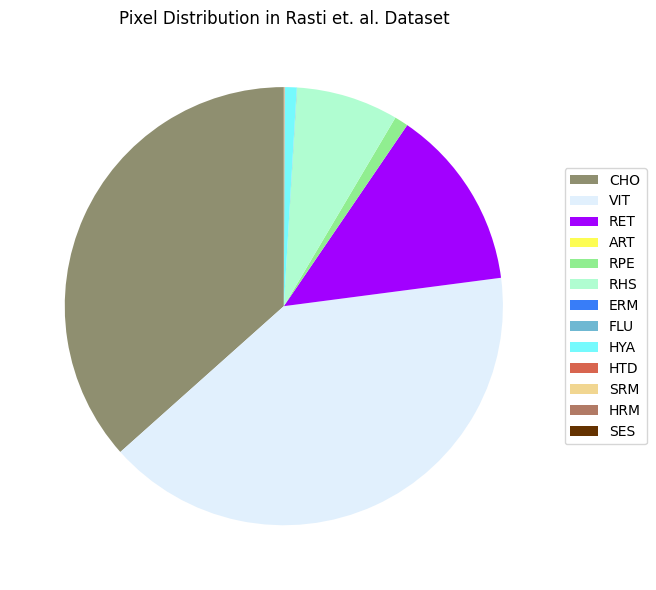

In [7]:
plot_pie_chart(label_map, total_label_count, color_map, save=True, suffix=f"legend")